# BLU2 - Learning Notebook - Part 2 of 3 - Identifying time series components

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
% matplotlib inline

# Identifying time series components

In the previous notebook, we introduced the four components that a time series can have. The modelling phase is dependent on the presence/absence of one or more of those components. We will discuss later why are they important.

Let's get back to our airline dataset.

In [19]:
from utils import load_airlines_series

In [20]:
data = load_airlines_series()

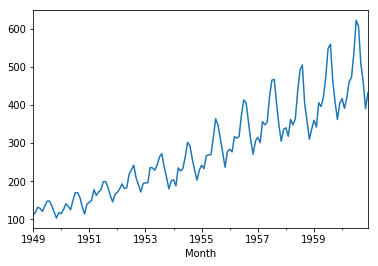

In [21]:
data.plot();

### Trend estimation

In the previous notebook, we already saw a way to estimate the trend by **using a linear regression**. This trend estimation method assumes that the trend is **linear**.

The process is quite simple:

In [22]:
from sklearn.linear_model import LinearRegression

create an integer numpy array with the number of the time step

In [23]:
# don't worry if you don't understand this first step, it's quite simple:  
# X will just be the 0, 1, 2, 3 on the left instead of the dates
X = data.reset_index().index.values.reshape(-1, 1)  

print(data.reset_index().head(5))

       Month  thousands of passengers
0 1949-01-01                    112.0
1 1949-02-01                    118.0
2 1949-03-01                    132.0
3 1949-04-01                    129.0
4 1949-05-01                    121.0


fit a simple linear regression that maps the time step to the observed time series

In [24]:
slr = LinearRegression(fit_intercept=True)

slr.fit(X, data)

linear_trend = pd.Series(slr.predict(X), index=data.index)

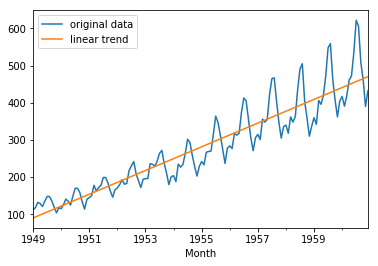

In [25]:
data.plot(label="original data")
linear_trend.plot(label="linear trend")
plt.legend();

Let's also check the R² score of this simple model

In [26]:
slr.score(X, data)

0.85363816560318795

Not bad for a really simple model!

Another very common approach to trend estimation is the **moving average**. You already used this method in BLU1. With this method, you need to set the window size. Let's start with a window size of 6 (months)

In [27]:
moving_avg_6_months = data.rolling(6).mean()
moving_avg_6_months.head(10)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01    124.500000
1949-07-01    130.500000
1949-08-01    135.500000
1949-09-01    136.166667
1949-10-01    134.500000
Name: thousands of passengers, dtype: float64

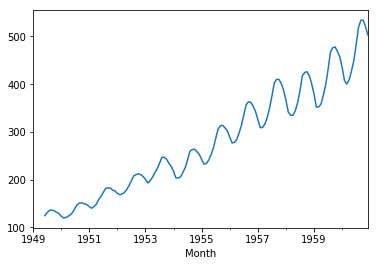

In [28]:
moving_avg_6_months.plot();

As you noticed, there are 5 NaNs in the moving average series. That is because the first 5 elements do not have enough data for a window of 6. We can "fix" this by setting `min_periods` to 0

In [29]:
moving_avg_6_months_ = data.rolling(6, min_periods=0).mean()
moving_avg_6_months_.head(10)

Month
1949-01-01    112.000000
1949-02-01    115.000000
1949-03-01    120.666667
1949-04-01    122.750000
1949-05-01    122.400000
1949-06-01    124.500000
1949-07-01    130.500000
1949-08-01    135.500000
1949-09-01    136.166667
1949-10-01    134.500000
Name: thousands of passengers, dtype: float64

Setting `min_periods` to something smaller than 6 will make pandas copy the values from the original series into the moving average series. To see that is the case, let's look at the original series 

In [30]:
data.head(10)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
Name: thousands of passengers, dtype: float64

Let's see how it looks in a plot

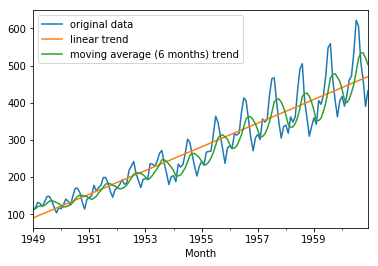

In [31]:
data.plot(label="original data")
linear_trend.plot(label="linear trend")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
plt.legend();

We should note that setting `min_periods` to 0 is fine for visualization purposes BUT once you start using trend estimation to prepare your time series for modelling, using `min_periods=0` is not ok at al.

What if we used a larger window? Like, for example, 12 months

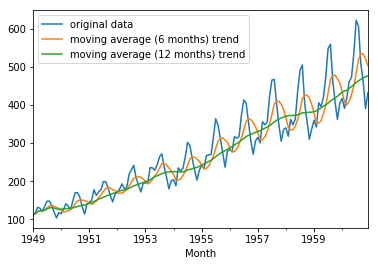

In [32]:
moving_avg_12_months_ = data.rolling(12, min_periods=0).mean()

data.plot(label="original data")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
moving_avg_12_months_.plot(label="moving average (12 months) trend")
plt.legend();

And what about 24 months?

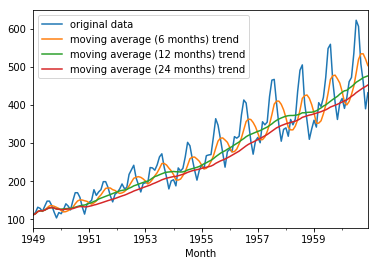

In [33]:
moving_avg_24_months_ = data.rolling(24, min_periods=0).mean()

data.plot(label="original data")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
moving_avg_12_months_.plot(label="moving average (12 months) trend")
moving_avg_24_months_.plot(label="moving average (24 months) trend")
plt.legend();

Everytime we increase the window size for the moving average, we get a smoother and more stable time series. But...what is a good window size? The answer is: it depends on your business expectations OR what preprocessing you require for your time series.

Also, a final note about trend estimation: several existing techniques for trend estimation include both the trend and cyclical components.

**A word of caution about linear trend estimation:** 

The linear trend estimation isn't always useful. For example, let's take a modified version of a time series about electricity consumption

In [34]:
from utils import load_electricity_consumption_series

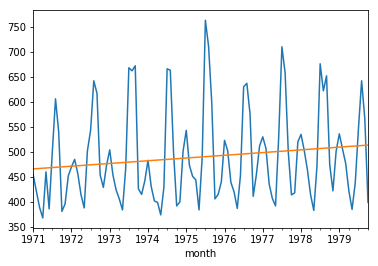

In [35]:
ts = load_electricity_consumption_series()['consumption']

slr = LinearRegression()

slr.fit(np.arange(ts.shape[0]).reshape(-1, 1), ts)

slr_pred = slr.predict(np.arange(ts.shape[0]).reshape(-1, 1))
slr_pred = pd.Series(slr_pred, index=ts.index)

ts.plot()
slr_pred.plot();

Would you consider this trend estimation useful at all? You might not a global monotonic trend but there is a cyclical component present: if you look closely, you will notice two "arches" on each side of the big peak at the middle. We will uncover that structure later on this notebook.

### Seasonal Decomposition

In the previous notebook, we saw two ways of combining the time series components: additive ($Y = T + C + S + I$) and multiplicative ($Y = T \cdot C \cdot S \cdot I$). But...how do we know if our time series is additive or multiplicative? Citing [Hyndman & Athanasopoulos](https://otexts.org/fpp2/components.html)

> _The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series._

There are several ways to implement this: using [moving averages](https://otexts.org/fpp2/classical-decomposition.html), [X11](https://otexts.org/fpp2/x11.html), [SEATS](https://otexts.org/fpp2/seats.html) and [STL](https://otexts.org/fpp2/stl.html). In this BLU, we will use the moving averages approach that was implemented in [statsmodel](https://www.statsmodels.org/stable/index.html), a python module with a rich set of plots, models and validation procedures for time series.

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/samuelhopkins/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [37]:
ts = load_airlines_series()

We need to choose if we will use `model=additive` or `model=multiplicative`. In order to do that, we have to look at our time series and follow the Hyndman & Athanasopoulos guidelines

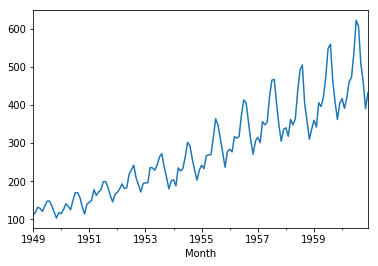

In [38]:
ts.plot();

It seems that the variance around the trend (remember the linear trend estimation?) is increasing throughout time. To check that visually, let's use the `pandas.Series.rolling.std` and plot the result

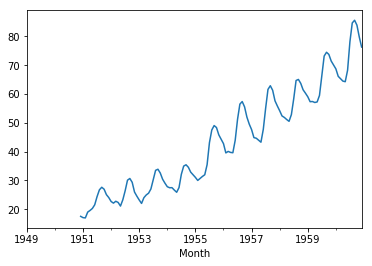

In [39]:
ts.rolling(24).std().plot();

using the previous plot, we can confirm that the variance of this time series increases throughout time. As such, let's use the multiplicative model for decomposition

In [40]:
decomposition = seasonal_decompose(ts, model='multiplicative')
decomposition

with this object, we have access to the estimation of the following components: 
* Trend-Cyclical
* Seasonal
* Irregular

statsmodel includes a function to plot all 3 components at once

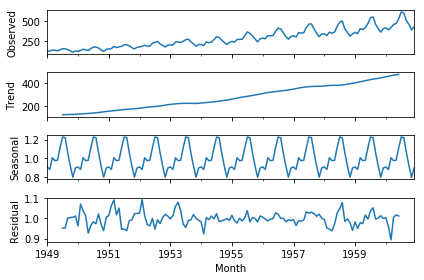

In [41]:
decomposition.plot()
plt.show()

also, we have direct access to all 3 components

In [42]:
decomposition.trend.head(10)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
Name: thousands of passengers, dtype: float64

In [43]:
decomposition.seasonal.head(10)

Month
1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
1949-06-01    1.112776
1949-07-01    1.226556
1949-08-01    1.219911
1949-09-01    1.060492
1949-10-01    0.921757
Name: thousands of passengers, dtype: float64

In [44]:
decomposition.resid.head(10)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.951664
1949-08-01    0.953401
1949-09-01    1.002220
1949-10-01    1.004028
Name: thousands of passengers, dtype: float64

### Similarity with the past

Later on, we will create models to forecast based on previous endogenous observations. For that kind of modelling, we need to choose how many steps in the past (i.e. lags) our model will consider to produce a prediction. In order to choose how many lags we will use, we have several tools at our disposal. In this section, we will present two of them: lags scatter plot and autocorrelation, both of them visual approaches.

#### Lags Scatter

A very simple way to visually assess the temporal relationships within a time series is through the use of lags scatter: draw a scatter plot between the *y(t)* and *y(t-lag)*

In [45]:
ts = load_airlines_series()

In [46]:
from pandas.plotting import lag_plot

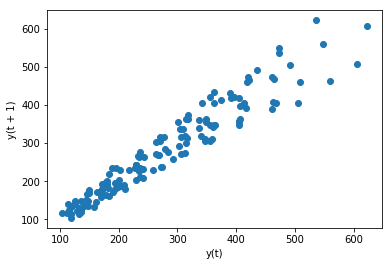

In [51]:
lag_plot(ts, lag=1);

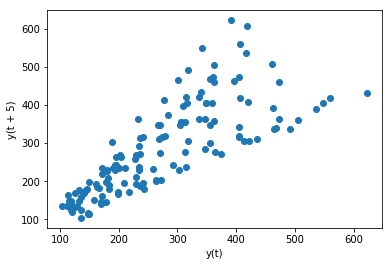

In [52]:
lag_plot(ts, lag=5);

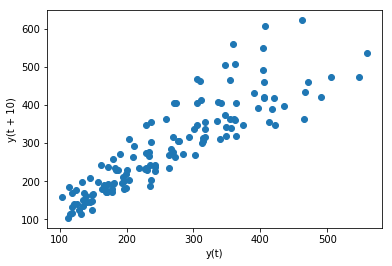

In [53]:
lag_plot(ts, lag=10);

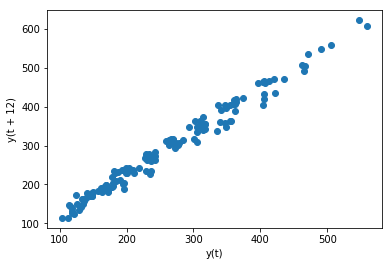

In [54]:
lag_plot(ts, lag=12);

This is hinting at a very important concept: auto-correlation. For more on auto-correlation, and how we can use it for forecasting, move right along on part 3 - Prediction! 